In [1]:
import numpy as np
import sigmf
import scipy
import matplotlib.pyplot as plt
from py3gpp import *

In [2]:
handle = sigmf.sigmffile.fromfile('30720KSPS_dl_signal.sigmf-data')
delta_f = 0
f = 1
mu = 0
apply_fine_CFO = 0

waveform = handle.read_samples()
waveform /= max(waveform.real.max(), waveform.imag.max()) # scale max amplitude to 1
fs = handle.get_global_field(sigmf.SigMFFile.SAMPLE_RATE_KEY)

detected NID2 is 2


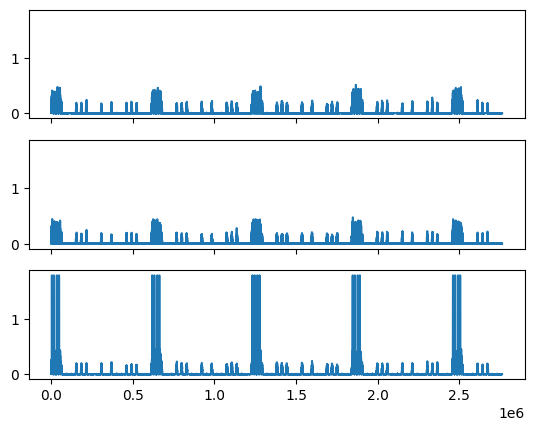

In [3]:
carrier = nrCarrierConfig(NSizeGrid = 106)

peak_value = np.zeros(3)
peak_index = np.zeros(3, 'int')
pssIndices = np.arange((635-63), (635+64))
fig, axs = plt.subplots(3, 1, facecolor='w', sharex=True, sharey=True)
for current_NID2 in np.arange(3, dtype='int'):
    slotGrid = nrResourceGrid(carrier)
    slotGrid = slotGrid[:, 0]
    slotGrid[pssIndices] = nrPSS(current_NID2)
    refWaveform, info = nrOFDMModulate(carrier, slotGrid)
    refWaveform = refWaveform[161:]; # remove CP
    #waveform.shape, info, waveform[:10]

    temp = scipy.signal.correlate(waveform, refWaveform, 'valid')
    peak_index[current_NID2] = np.argmax(np.abs(temp))
    peak_value[current_NID2] = np.abs(temp[peak_index[current_NID2]])
    axs[current_NID2].plot(np.abs(temp))
    temp
detected_NID2 = np.argmax(peak_value)
print(f'detected NID2 is {detected_NID2}')

In [4]:
mu = 0
cp1 = np.round(5.2e-6*fs * 2**(-mu))
cp2 = np.round(4.7e-6*fs * 2**(-mu))
timingOffset = int(35264 - 2048 - cp1 - cp2)

# TODO: implement nrTimingEstimate

In [5]:
nrbSSB = 20
scsSSB = 15
nSlot = 0
rxSampleRate = fs
rxGrid = nrOFDMDemodulate(waveform = waveform[timingOffset:], nrb = nrbSSB, scs = scsSSB, initialNSlot = nSlot, SampleRate=rxSampleRate)
rxGrid = rxGrid[:,1:4]

Text(0.5, 0.95, 'SSS symbols')

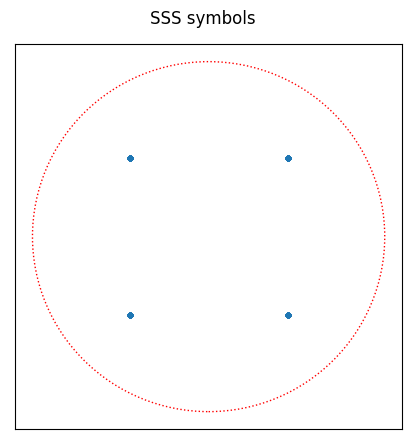

In [12]:
subcarriers_ss_SSB = slice(240//2 - 64, 240//2 +63)

# TODO: implement nrSSSIndices() and nrExtractResources()

fig, axs = plt.subplots(1, 1, figsize=(5, 5), facecolor='w', sharex=True, sharey=True)
axs.plot(rxGrid[subcarriers_ss_SSB, 1].real, rxGrid[subcarriers_ss_SSB, 1].imag, '.')
axs.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
axs.set_xticks([])
axs.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('SSS symbols', y=0.95)

detected NID1 is 69
detected NID is 209


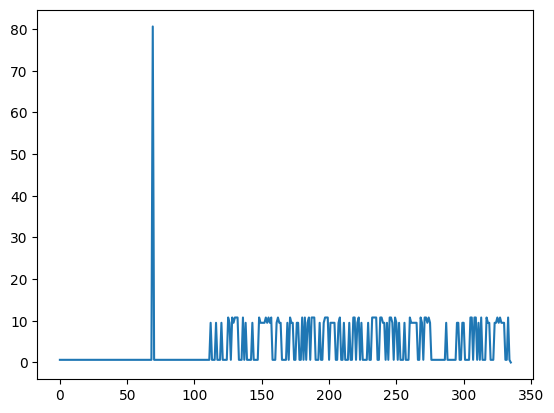

In [16]:
sssRx = rxGrid[subcarriers_ss_SSB, 2]

sssEst = np.zeros(336)
for NID1 in range(335):
    ncellid = (3*NID1) + detected_NID2
    sssRef = nrSSS(ncellid)
    sssEst[NID1] = np.abs(np.vdot(sssRx, sssRef))

detected_NID1 = np.argmax(sssEst)
print(f'detected NID1 is {detected_NID1}')
print(f'detected NID is {detected_NID1*3 + detected_NID2}')
plt.plot(sssEst)
plt.show()